In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Excercise 1.4
--------------------------------------------------
µ = 0 implies that at T the investor will want to hold zero shares of the asset because in this case at the terminal date the max value of the function will be obtained only when n_T=0. It corresponds to the ‘optimal liquidation’ of a position within one day.

In [86]:
#Trading paramenters
mu      = 0
gamma   = 1
n0  = 1000000
sigma_ann = 0.3
timing_30 = pd.date_range('09:30:00','16:00:00',freq="30min")
timing_10 = pd.date_range('09:30:00','16:00:00',freq="10min")
lunch_start = '12:00:00'
lunch_end = '14:00:00'
#trading costs
lmbda_l=0.0001
lmbda_h=0.0002

In [87]:
# adjust lambda if we have lunch
def adj_lmbda(schedule,lmbda_l,lmbda_h): 
    T = len(schedule)
    start = pd.to_datetime(lunch_start)
    end = pd.to_datetime(lunch_end)
    lmbda = np.ones((T,1))
    diff=lmbda_h-lmbda_l
    for t in range(T): 
        lmbda[t] = lmbda_l + (schedule[t]>=start)*(schedule[t]<=end)*diff
    return lmbda

def optimal_trading(mu,gamma,n0,sigma_ann,schedule,lmbda_l,lmbda_h,lunch=True):
    
    #trading parameters that depend on frequency
    T = len(schedule)
    sigma = sigma_ann/np.sqrt(252*(T-1))
    lmbda = np.ones((T,1))*lmbda_l
    
    #adjust lambda if there is lunch
    if lunch:
        lmbda=adj_lmbda(schedule,lmbda_l,lmbda_h)

    #Coefficients of the value function
    Q = np.ones((T+1,1))
    q = np.ones((T+1,1))
    C = np.ones((T+1,1))
    Q[T] = 0
    q[T] = 0
    C[T] = 0
    for t in range(T-1,0,-1): 
        Q[t] = lmbda[t]-(lmbda[t]**2/(lmbda[t]+gamma*sigma**2+Q[t+1]))
        q[t] = lmbda[t]*(q[t+1]+mu)/(lmbda[t]+gamma*sigma**2+Q[t+1])
        C[t] = 0.5*(q[t+1]+mu)**2/(lmbda[t]+gamma*sigma**2+Q[t+1])+C[t+1]

    #Optimal trading:
    tau = np.divide(Q[:-1],lmbda)     #trading speed
    aim = np.divide(q[:-1],Q[:-1])    #aim portfolio
    n = np.empty((T,1))
    n[0] = n0
    tcost = np.empty((T,1))
    tcost[0] = 0
    for t in range(1,T,1): 
        n[t] = tau[t]*aim[t]+(1-tau[t])*n[t-1]
        tcost[t] = tcost[t-1]+0.5*lmbda[t]*(n[t]-n[t-1])**2
    return n,tcost,tau,aim

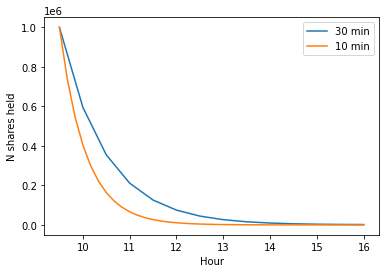

In [88]:
#saving optimal trading data (without lunch)
n30,tcost30,tau30,aim30 = optimal_trading(mu,gamma,n0,sigma_ann,timing_30,lmbda_l,lmbda_h,lunch=False)
n10,tcost10,tau10,aim10 = optimal_trading(mu,gamma,n0,sigma_ann,timing_10,lmbda_l,lmbda_h,lunch=False)

#plot the number of shares held during the day (trading schedule)
fig = plt.figure()
x = fig.add_subplot()
x.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
min30 = x.plot(timing_30,n30,label="30 min")
min10 = x.plot(timing_10,n10,label="10 min")
plt.xlabel('Hour')
plt.ylabel('N shares held')
plt.legend()
plt.show()

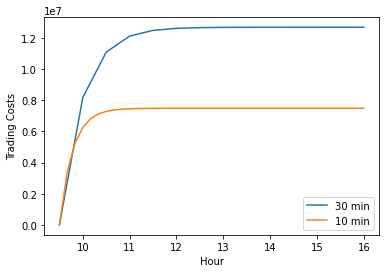

In [89]:
#plot the expected trading costs of the optimal trading strategy
fig = plt.figure()
x = fig.add_subplot()
x.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
min30 = x.plot(timing_30,tcost30,label="30 min")
min10 = x.plot(timing_10,tcost10,label="10 min")
plt.xlabel('Hour')
plt.ylabel('Trading Costs')
plt.legend()
plt.show()

Excercise 1.5
--------------------------------------------------
In our model it can be seen that there is no dependency on the realized price shocks. It depends on the previous states only through the trading costs, which doesn't depend on the price, but only on the number of shares traded. Since we deal with the intraday trading, on the one hand, depending on the purpose of the trade (for example, long-term investor liquidating position) it may be reasonable that the model doesn't depend on the past prices because the current parameters of the optimal portfolio are unlikely to change substantially in one day, but the estimations are tedious. On the other hand, it seems to be very unrealistic that the volatility and return parameters stays the same during the trading day and in the case of the high frequency trading it doesn't seem reasonable to use such a model. It could be optimal because reestimation of the parameters at each step is very tedious and involves computations, which might take too much time
In order to account for the realized price shocks the following model modificatons can be done:
1. the t-cost can depend on the price of the asset instead of the number of assets traded;
2. the risk aversion of the investors can depend on their wealth: he will trade faster towards his optimal portfolio in the situation when prices fall;
3. t-costs can depend on the state of the market: higher costs in case of falling market since there is less liquidity.

Excercise 1.6
--------------------------------------------------

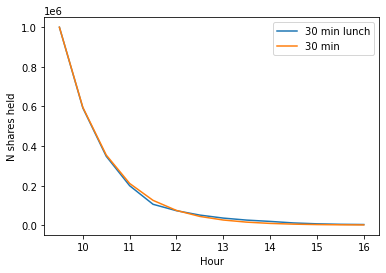

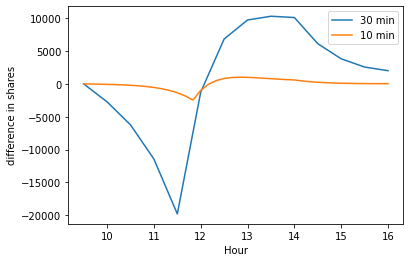

In [90]:
##saving optimal trading data (with lunch)
n30lunch,tcost30lunch,tau30lunch,aim30lunch = optimal_trading(mu,gamma,n0,sigma_ann,timing_30,lmbda_l,lmbda_h)
n10lunch,tcost10lunch,tau10lunch,aim10lunch = optimal_trading(mu,gamma,n0,sigma_ann,timing_10,lmbda_l,lmbda_h)

#plot the number of shares held during the day for the trading with and without lunch break for 30min interval
fig = plt.figure()
x = fig.add_subplot()
x.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
min30lunch = x.plot(timing_30,n30lunch,label="30 min lunch")
min30 = x.plot(timing_30,n30,label="30 min")
plt.xlabel('Hour')
plt.ylabel('N shares held')
plt.legend()
plt.show()

#plot the difference in the number of shares: optimal treding with lunch - optimal trading with lunch
fig = plt.figure()
x = fig.add_subplot()
x.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
min30 = x.plot(timing_30,n30lunch-n30,label="30 min")
min10 = x.plot(timing_10,n10lunch-n10,label="10 min")
plt.xlabel('Hour')
plt.ylabel('difference in shares')
plt.legend()
plt.show()

In order to account for the stylized fact about stock liquidity, we can model t-costs as a fuction of time instead of assuming that it's constant. In our case it could be done in the followilg way:
$\lambda_t= \lambda(t) = 1_{\{t\in L\}}\lambda_{high} + 1_{\{t\notin L\}}\lambda_{low}$, where $L$ is a set of time steps that belong to the lunch break.

On the first graph above the number of shares held during the day for the trading with and without lunch break (30min interval) is plotted. It can be noticed that the investor trades slightly more aggressive before the lunch break and, as a result, has less shares before the lunch break. During the break the trading activity drops since the costs are high and by the end of the break the number of shares held is greater than in the case of the constant t-costs. However, after the lunch break the trading speed is higher again and the number of shares held converge to the number of shares held when the costs are constant. In order to see it better the difference in shares held during the day for both cases is plotted on the second graph.